In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.3
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# read data from file
df = pd.read_csv("./data/AdvectionDiffusion/noise_00.csv")
x = df[['x', 'y', 'z', 't']].values
y = df['u'].values
u_t = df['u_t'].values
u_x = df['u_x'].values
u_y = df['u_y'].values
u_z = df['u_z'].values
u_xx = df['u_xx'].values
u_yy = df['u_yy'].values
u_zz = df['u_zz'].values

from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(2812, 4) (2812,)
(938, 4) (938,)
(1250, 4) (1250,)


In [3]:
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-5):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation="sigmoid",
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                    activation = "sigmoid"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-10)]

In [4]:
# reconstruct the machine learning model
def s(input_x, input_y, input_z, input_t):
    i = 0
    for w, b in zip(kernel_tensor, bias_tensor):
        if i == 0:
            input_tensor = input_x*w[0,:] + input_y*w[1,:] + input_z*w[2,:] + input_t*w[3,:] + b
            input_tensor = tf.nn.sigmoid(input_tensor)
        elif i < len(kernel_tensor)-1:
            output_tensor = input_tensor@w + b
            output = tf.nn.sigmoid(output_tensor)
            input_tensor = output
        else:
            output_tensor = input_tensor@w + b
            output = output_tensor
        i += 1
    return output

In [5]:
input_array = x
input_x = tf.Variable(input_array[:, 0].reshape(5000, 1))
input_y = tf.Variable(input_array[:, 1].reshape(5000, 1))
input_z = tf.Variable(input_array[:, 2].reshape(5000, 1))
input_t = tf.Variable(input_array[:, 3].reshape(5000, 1))

In [10]:
sizes = [i for i in range(10, 101, 1)]
dx = []
dy = []
dz = []
dt = []
dxx = []
dyy = []
dzz = []
print("layers: ", sizes)

layers:  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [11]:
for layer_size in sizes:
    model = build_model(hidden_layers = 4, layer_size = layer_size)
    history = model.fit(x_train, y_train, epochs = 100,
                        validation_data = (x_valid, y_valid),
                        callbacks = callbacks)
    from tensorflow import float64
    # get weights and bias in each layer
    i = 0
    kernel_tensor = []
    bias_tensor = []
    for each in model.weights:
        if i % 2 is 0:
            kernel_tensor.append(tf.constant(each.numpy(), dtype=float64))
        else:
            bias_tensor.append(tf.constant(each.numpy(), dtype=float64))
        i += 1
    # first derivatives
    with tf.GradientTape(persistent=True) as tape:
        output = s(input_x, input_y, input_z, input_t)
        
    ds_x = tape.gradient(output, input_x).numpy()
    ds_y = tape.gradient(output, input_y).numpy()
    ds_z = tape.gradient(output, input_z).numpy()
    ds_t = tape.gradient(output, input_t).numpy()

    del tape
    dx.append((ds_x.reshape(len(ds_x))-u_x).sum()/len(ds_x))
    dy.append((ds_y.reshape(len(ds_y))-u_y).sum()/len(ds_y))
    dz.append((ds_z.reshape(len(ds_z))-u_z).sum()/len(ds_z))
    dt.append((ds_t.reshape(len(ds_t))-u_t).sum()/len(ds_t))
    # second derivatives
    with tf.GradientTape(persistent=True) as outer_tape:
        with tf.GradientTape(persistent=True) as inner_tape:
            output = s(input_x, input_y, input_z, input_t)
        inner_grads = inner_tape.gradient(output, [input_x, input_y, input_z])
    # outer_grads = [outer_tape.gradient(inner_grad, [input_x, input_y, input_z]) for inner_grad in inner_grads]
    ds_xx = outer_tape.gradient(inner_grads[0], [input_x])[0].numpy()
    ds_yy = outer_tape.gradient(inner_grads[1], [input_y])[0].numpy()
    ds_zz = outer_tape.gradient(inner_grads[2], [input_z])[0].numpy()

    del inner_tape
    del outer_tape
    dxx.append((ds_xx.reshape(len(ds_xx))-u_xx).sum()/len(ds_xx))
    dyy.append((ds_yy.reshape(len(ds_yy))-u_yy).sum()/len(ds_yy))
    dzz.append((ds_zz.reshape(len(ds_zz))-u_zz).sum()/len(ds_zz))

Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 113us/sample - loss: 0.0979 - val_loss: 0.0843
Epoch 2/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0960 - val_loss: 0.0826
Epoch 3/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0942 - val_loss: 0.0809
Epoch 4/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0925 - val_loss: 0.0794
Epoch 5/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0909 - val_loss: 0.0779
Epoch 6/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0894 - val_loss: 0.0765
Epoch 7/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0879 - val_loss: 0.0752
Epoch 8/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0865 - val_loss: 0.0739
Epoch 9/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0851 - val_loss: 0.072

2812/2812 [==============================] - 0s 30us/sample - loss: 0.0580 - val_loss: 0.0494
Epoch 78/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0579 - val_loss: 0.0494
Epoch 79/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0579 - val_loss: 0.0494
Epoch 80/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0578 - val_loss: 0.0493
Epoch 81/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0578 - val_loss: 0.0493
Epoch 82/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 83/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 84/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0577 - val_loss: 0.0492
Epoch 85/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0576 - val_loss: 0.0492
Epoch 86/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0870 - val_loss: 0.0743
Epoch 54/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0857 - val_loss: 0.0732
Epoch 55/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0846 - val_loss: 0.0721
Epoch 56/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0834 - val_loss: 0.0711
Epoch 57/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0823 - val_loss: 0.0701
Epoch 58/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0813 - val_loss: 0.0692
Epoch 59/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0803 - val_loss: 0.0683
Epoch 60/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0793 - val_loss: 0.0674
Epoch 61/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0784 - val_loss: 0.0666
Epoch 62/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0572 - val_loss: 0.0501
Epoch 30/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0572 - val_loss: 0.0501
Epoch 31/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0572 - val_loss: 0.0501
Epoch 32/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0572 - val_loss: 0.0500
Epoch 33/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0571 - val_loss: 0.0500
Epoch 34/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0500
Epoch 35/100
2812/2812 [==============================] - 0s 44us/sample - loss: 0.0571 - val_loss: 0.0499
Epoch 36/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0499
Epoch 37/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0499
Epoch 38/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.3396 - val_loss: 0.3110
Epoch 6/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.3245 - val_loss: 0.2967
Epoch 7/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.3103 - val_loss: 0.2832
Epoch 8/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2968 - val_loss: 0.2704
Epoch 9/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2840 - val_loss: 0.2583
Epoch 10/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2720 - val_loss: 0.2469
Epoch 11/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2605 - val_loss: 0.2361
Epoch 12/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2497 - val_loss: 0.2259
Epoch 13/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.2395 - val_loss: 0.2162
Epoch 14/100
2812/2812 [==============================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0617 - val_loss: 0.0522
Epoch 82/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0614 - val_loss: 0.0520
Epoch 83/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0612 - val_loss: 0.0518
Epoch 84/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0610 - val_loss: 0.0516
Epoch 85/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0608 - val_loss: 0.0515
Epoch 86/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0606 - val_loss: 0.0513
Epoch 87/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0604 - val_loss: 0.0512
Epoch 88/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0602 - val_loss: 0.0511
Epoch 89/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0601 - val_loss: 0.0510
Epoch 90/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.1356 - val_loss: 0.1330
Epoch 58/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1320 - val_loss: 0.1294
Epoch 59/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1286 - val_loss: 0.1259
Epoch 60/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1253 - val_loss: 0.1225
Epoch 61/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.1222 - val_loss: 0.1193
Epoch 62/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.1193 - val_loss: 0.1163
Epoch 63/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.1164 - val_loss: 0.1134
Epoch 64/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1137 - val_loss: 0.1106
Epoch 65/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.1111 - val_loss: 0.1079
Epoch 66/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0734 - val_loss: 0.0685
Epoch 34/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0725 - val_loss: 0.0675
Epoch 35/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0717 - val_loss: 0.0666
Epoch 36/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0709 - val_loss: 0.0657
Epoch 37/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0701 - val_loss: 0.0649
Epoch 38/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0694 - val_loss: 0.0641
Epoch 39/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0687 - val_loss: 0.0634
Epoch 40/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0681 - val_loss: 0.0627
Epoch 41/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0674 - val_loss: 0.0620
Epoch 42/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0857 - val_loss: 0.0730
Epoch 10/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0841 - val_loss: 0.0715
Epoch 11/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0825 - val_loss: 0.0701
Epoch 12/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0810 - val_loss: 0.0688
Epoch 13/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0797 - val_loss: 0.0676
Epoch 14/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0783 - val_loss: 0.0664
Epoch 15/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0771 - val_loss: 0.0653
Epoch 16/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0760 - val_loss: 0.0643
Epoch 17/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0749 - val_loss: 0.0634
Epoch 18/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 86/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0491
Epoch 87/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0491
Epoch 88/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 89/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 90/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 91/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 92/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 93/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 94/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0636 - val_loss: 0.0538
Epoch 62/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0633 - val_loss: 0.0535
Epoch 63/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0630 - val_loss: 0.0533
Epoch 64/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0627 - val_loss: 0.0530
Epoch 65/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0625 - val_loss: 0.0528
Epoch 66/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0622 - val_loss: 0.0526
Epoch 67/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0620 - val_loss: 0.0524
Epoch 68/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0618 - val_loss: 0.0522
Epoch 69/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0615 - val_loss: 0.0521
Epoch 70/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.2372 - val_loss: 0.2338
Epoch 38/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2253 - val_loss: 0.2219
Epoch 39/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2142 - val_loss: 0.2108
Epoch 40/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2038 - val_loss: 0.2005
Epoch 41/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1941 - val_loss: 0.1908
Epoch 42/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.1850 - val_loss: 0.1818
Epoch 43/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.1766 - val_loss: 0.1733
Epoch 44/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1687 - val_loss: 0.1654
Epoch 45/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1613 - val_loss: 0.1580
Epoch 46/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.4568 - val_loss: 0.4202
Epoch 14/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.4309 - val_loss: 0.3957
Epoch 15/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.4067 - val_loss: 0.3728
Epoch 16/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3840 - val_loss: 0.3513
Epoch 17/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3628 - val_loss: 0.3313
Epoch 18/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3431 - val_loss: 0.3127
Epoch 19/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3245 - val_loss: 0.2952
Epoch 20/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3072 - val_loss: 0.2789
Epoch 21/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.2910 - val_loss: 0.2636
Epoch 22/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0595 - val_loss: 0.0505
Epoch 90/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0593 - val_loss: 0.0504
Epoch 91/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0592 - val_loss: 0.0503
Epoch 92/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0590 - val_loss: 0.0502
Epoch 93/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0589 - val_loss: 0.0501
Epoch 94/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0588 - val_loss: 0.0500
Epoch 95/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0587 - val_loss: 0.0499
Epoch 96/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0585 - val_loss: 0.0498
Epoch 97/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0584 - val_loss: 0.0498
Epoch 98/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0595 - val_loss: 0.0504
Epoch 66/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0593 - val_loss: 0.0503
Epoch 67/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0591 - val_loss: 0.0502
Epoch 68/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0589 - val_loss: 0.0501
Epoch 69/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0588 - val_loss: 0.0500
Epoch 70/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0587 - val_loss: 0.0499
Epoch 71/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0585 - val_loss: 0.0498
Epoch 72/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0584 - val_loss: 0.0497
Epoch 73/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0583 - val_loss: 0.0496
Epoch 74/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0613 - val_loss: 0.0518
Epoch 42/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0609 - val_loss: 0.0516
Epoch 43/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0607 - val_loss: 0.0513
Epoch 44/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0604 - val_loss: 0.0511
Epoch 45/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0601 - val_loss: 0.0510
Epoch 46/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0599 - val_loss: 0.0508
Epoch 47/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0597 - val_loss: 0.0506
Epoch 48/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0595 - val_loss: 0.0505
Epoch 49/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0593 - val_loss: 0.0504
Epoch 50/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0757 - val_loss: 0.0707
Epoch 29/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0743 - val_loss: 0.0692
Epoch 30/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0730 - val_loss: 0.0678
Epoch 31/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0718 - val_loss: 0.0665
Epoch 32/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0706 - val_loss: 0.0653
Epoch 33/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0696 - val_loss: 0.0641
Epoch 34/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0686 - val_loss: 0.0631
Epoch 35/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0677 - val_loss: 0.0622
Epoch 36/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0669 - val_loss: 0.0613
Epoch 37/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.1421 - val_loss: 0.1235
Epoch 5/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1349 - val_loss: 0.1170
Epoch 6/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.1283 - val_loss: 0.1110
Epoch 7/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1223 - val_loss: 0.1055
Epoch 8/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1168 - val_loss: 0.1005
Epoch 9/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1117 - val_loss: 0.0959
Epoch 10/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1071 - val_loss: 0.0917
Epoch 11/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1029 - val_loss: 0.0879
Epoch 12/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0990 - val_loss: 0.0845
Epoch 13/100
2812/2812 [==============================]

2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0491
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 141us/sample - loss: 0.4225 - val_loss: 0.4135
Epoch 2/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.3916 - val_loss: 0.3834
Epoch 3/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.3634 - val_loss: 0.3557
Epoch 4/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.3375 - val_loss: 0.3305
Epoch 5/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.3139 - val_loss: 0.3073
Epoch 6/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2922 - val_loss: 0.2861
Epoch 7/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.2724 - val_loss: 0.2666
Epoch 8/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2543 - val_loss: 0.2488
Epoch 9/10

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0577 - val_loss: 0.0505
Epoch 77/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0576 - val_loss: 0.0504
Epoch 78/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0576 - val_loss: 0.0503
Epoch 79/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0575 - val_loss: 0.0503
Epoch 80/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0575 - val_loss: 0.0502
Epoch 81/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0575 - val_loss: 0.0502
Epoch 82/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0575 - val_loss: 0.0501
Epoch 83/100
2812/2812 [==============================] - 0s 30us/sample - loss: 0.0574 - val_loss: 0.0501
Epoch 84/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0574 - val_loss: 0.0501
Epoch 85/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 31us/sample - loss: 0.0618 - val_loss: 0.0556
Epoch 53/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0614 - val_loss: 0.0552
Epoch 54/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0610 - val_loss: 0.0548
Epoch 55/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0607 - val_loss: 0.0544
Epoch 56/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0604 - val_loss: 0.0540
Epoch 57/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0601 - val_loss: 0.0537
Epoch 58/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0598 - val_loss: 0.0533
Epoch 59/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0596 - val_loss: 0.0531
Epoch 60/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0594 - val_loss: 0.0528
Epoch 61/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0620 - val_loss: 0.0523
Epoch 29/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0615 - val_loss: 0.0520
Epoch 30/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0611 - val_loss: 0.0517
Epoch 31/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0607 - val_loss: 0.0514
Epoch 32/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0604 - val_loss: 0.0511
Epoch 33/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0601 - val_loss: 0.0509
Epoch 34/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0598 - val_loss: 0.0507
Epoch 35/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0596 - val_loss: 0.0505
Epoch 36/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0593 - val_loss: 0.0504
Epoch 37/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0600 - val_loss: 0.0508
Epoch 37/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0597 - val_loss: 0.0506
Epoch 38/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0595 - val_loss: 0.0505
Epoch 39/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0593 - val_loss: 0.0503
Epoch 40/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0591 - val_loss: 0.0502
Epoch 41/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0589 - val_loss: 0.0501
Epoch 42/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0587 - val_loss: 0.0499
Epoch 43/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0586 - val_loss: 0.0499
Epoch 44/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0585 - val_loss: 0.0498
Epoch 45/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0584 - val_loss: 0.0497
Epoch 41/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0583 - val_loss: 0.0497
Epoch 42/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0582 - val_loss: 0.0496
Epoch 43/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0581 - val_loss: 0.0495
Epoch 44/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0580 - val_loss: 0.0495
Epoch 45/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0579 - val_loss: 0.0494
Epoch 46/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0578 - val_loss: 0.0494
Epoch 47/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0578 - val_loss: 0.0494
Epoch 48/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 49/100
2812/2812 [==========================

Epoch 22/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.1932 - val_loss: 0.1870
Epoch 23/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.1790 - val_loss: 0.1731
Epoch 24/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1663 - val_loss: 0.1606
Epoch 25/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1549 - val_loss: 0.1495
Epoch 26/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1448 - val_loss: 0.1394
Epoch 27/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.1356 - val_loss: 0.1304
Epoch 28/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.1275 - val_loss: 0.1223
Epoch 29/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1201 - val_loss: 0.1151
Epoch 30/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1136 - val_loss: 0.1086
Epoch 31/100
2812/2812 [=============

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 99/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 100/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0494
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 108us/sample - loss: 0.5123 - val_loss: 0.4965
Epoch 2/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.4655 - val_loss: 0.4514
Epoch 3/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.4236 - val_loss: 0.4109
Epoch 4/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.3860 - val_loss: 0.3745
Epoch 5/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3522 - val_loss: 0.3419
Epoch 6/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3220 - val_loss: 0.3125
Epoch 7

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 75/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 76/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 77/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 78/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 79/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 80/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 81/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 82/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 83/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0709 - val_loss: 0.0654
Epoch 51/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0696 - val_loss: 0.0640
Epoch 52/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0684 - val_loss: 0.0627
Epoch 53/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0674 - val_loss: 0.0616
Epoch 54/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0664 - val_loss: 0.0606
Epoch 55/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0655 - val_loss: 0.0596
Epoch 56/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0647 - val_loss: 0.0588
Epoch 57/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0640 - val_loss: 0.0580
Epoch 58/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0633 - val_loss: 0.0573
Epoch 59/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0736 - val_loss: 0.0682
Epoch 27/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0720 - val_loss: 0.0665
Epoch 28/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0705 - val_loss: 0.0649
Epoch 29/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0691 - val_loss: 0.0635
Epoch 30/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0679 - val_loss: 0.0622
Epoch 31/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0668 - val_loss: 0.0611
Epoch 32/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0658 - val_loss: 0.0600
Epoch 33/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0650 - val_loss: 0.0590
Epoch 34/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0642 - val_loss: 0.0582
Epoch 35/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 32us/sample - loss: 0.4709 - val_loss: 0.4237
Epoch 3/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.4252 - val_loss: 0.3815
Epoch 4/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3846 - val_loss: 0.3441
Epoch 5/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3485 - val_loss: 0.3108
Epoch 6/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.3163 - val_loss: 0.2813
Epoch 7/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2877 - val_loss: 0.2551
Epoch 8/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2623 - val_loss: 0.2318
Epoch 9/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.2397 - val_loss: 0.2111
Epoch 10/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2196 - val_loss: 0.1927
Epoch 11/100
2812/2812 [==============================] -

2812/2812 [==============================] - 0s 32us/sample - loss: 1.0626 - val_loss: 1.0243
Epoch 5/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.9580 - val_loss: 0.9242
Epoch 6/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.8644 - val_loss: 0.8344
Epoch 7/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.7805 - val_loss: 0.7541
Epoch 8/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.7055 - val_loss: 0.6820
Epoch 9/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.6383 - val_loss: 0.6175
Epoch 10/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.5781 - val_loss: 0.5596
Epoch 11/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.5242 - val_loss: 0.5077
Epoch 12/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.4758 - val_loss: 0.4611
Epoch 13/100
2812/2812 [==============================]

2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0498
Epoch 81/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0498
Epoch 82/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 83/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 84/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0497
Epoch 85/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0496
Epoch 86/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0496
Epoch 87/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0496
Epoch 88/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 89/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0578 - val_loss: 0.0494
Epoch 57/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 58/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0576 - val_loss: 0.0493
Epoch 59/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0575 - val_loss: 0.0492
Epoch 60/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0575 - val_loss: 0.0492
Epoch 61/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 62/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 63/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 64/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 65/100
2812/2812 [==========================

Epoch 52/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 53/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 54/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 55/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 56/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 57/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 58/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0491
Epoch 59/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 60/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 61/100
2812/2812 [=============

Epoch 12/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.2952 - val_loss: 0.2826
Epoch 13/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.2638 - val_loss: 0.2526
Epoch 14/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.2365 - val_loss: 0.2265
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.2128 - val_loss: 0.2038
Epoch 16/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1923 - val_loss: 0.1840
Epoch 17/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1745 - val_loss: 0.1668
Epoch 18/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1590 - val_loss: 0.1518
Epoch 19/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1455 - val_loss: 0.1388
Epoch 20/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1339 - val_loss: 0.1275
Epoch 21/100
2812/2812 [=============

2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 89/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 90/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 91/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 92/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 93/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 94/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 95/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 96/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 97/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0499
Epoch 65/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0499
Epoch 66/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 67/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 68/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 69/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 70/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 71/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 72/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 73/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0613 - val_loss: 0.0517
Epoch 41/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0607 - val_loss: 0.0513
Epoch 42/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0602 - val_loss: 0.0509
Epoch 43/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0597 - val_loss: 0.0506
Epoch 44/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0594 - val_loss: 0.0504
Epoch 45/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0590 - val_loss: 0.0501
Epoch 46/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0588 - val_loss: 0.0500
Epoch 47/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0585 - val_loss: 0.0498
Epoch 48/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0583 - val_loss: 0.0497
Epoch 49/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 50/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 51/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 52/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 53/100
2812/2812 [==============================] - 0s 57us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 54/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 55/100
2812/2812 [==============================] - 0s 41us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 56/100
2812/2812 [==============================] - 0s 41us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 57/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 58/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0643 - val_loss: 0.0582
Epoch 26/100
2812/2812 [==============================] - 0s 42us/sample - loss: 0.0634 - val_loss: 0.0571
Epoch 27/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0626 - val_loss: 0.0562
Epoch 28/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0618 - val_loss: 0.0555
Epoch 29/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0612 - val_loss: 0.0548
Epoch 30/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0607 - val_loss: 0.0542
Epoch 31/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0602 - val_loss: 0.0536
Epoch 32/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0598 - val_loss: 0.0532
Epoch 33/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0594 - val_loss: 0.0527
Epoch 34/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 131us/sample - loss: 0.6206 - val_loss: 0.5859
Epoch 2/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.5363 - val_loss: 0.5069
Epoch 3/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.4646 - val_loss: 0.4397
Epoch 4/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.4037 - val_loss: 0.3825
Epoch 5/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.3519 - val_loss: 0.3337
Epoch 6/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.3079 - val_loss: 0.2922
Epoch 7/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2704 - val_loss: 0.2568
Epoch 8/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.2385 - val_loss: 0.2266
Epoch 9/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2115 - val_loss: 0.2009
Epoch 10/100
2812/2812 [==============================] -

Epoch 78/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 79/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 80/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 81/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 82/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 83/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 84/100
2812/2812 [==============================] - 0s 31us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 85/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 86/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 87/100
2812/2812 [=============

2812/2812 [==============================] - 0s 36us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 55/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 56/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 57/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 58/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0492
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 117us/sample - loss: 0.2970 - val_loss: 0.2581
Epoch 2/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.2605 - val_loss: 0.2255
Epoch 3/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.2296 - val_loss: 0.1980
Epoch 4/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2034 - val_loss: 0.1747
Epoch 

Epoch 22/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0671 - val_loss: 0.0562
Epoch 23/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0656 - val_loss: 0.0550
Epoch 24/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0642 - val_loss: 0.0539
Epoch 25/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0631 - val_loss: 0.0530
Epoch 26/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0622 - val_loss: 0.0523
Epoch 27/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0614 - val_loss: 0.0517
Epoch 28/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0607 - val_loss: 0.0512
Epoch 29/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0601 - val_loss: 0.0508
Epoch 30/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0596 - val_loss: 0.0505
Epoch 31/100
2812/2812 [=============

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 48/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 49/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 50/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 51/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 52/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 53/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 54/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 55/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0572 - val_loss: 0.0495
Epoch 56/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 34us/sample - loss: 0.0584 - val_loss: 0.0497
Epoch 38/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0582 - val_loss: 0.0495
Epoch 39/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0580 - val_loss: 0.0494
Epoch 40/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0578 - val_loss: 0.0493
Epoch 41/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0576 - val_loss: 0.0492
Epoch 42/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0575 - val_loss: 0.0492
Epoch 43/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0574 - val_loss: 0.0491
Epoch 44/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0491
Epoch 45/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0491
Epoch 46/100
2812/2812 [==========================

Epoch 10/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.1254 - val_loss: 0.1054
Epoch 11/100
2812/2812 [==============================] - 0s 49us/sample - loss: 0.1141 - val_loss: 0.0957
Epoch 12/100
2812/2812 [==============================] - 0s 43us/sample - loss: 0.1047 - val_loss: 0.0876
Epoch 13/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0969 - val_loss: 0.0809
Epoch 14/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0903 - val_loss: 0.0753
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0848 - val_loss: 0.0707
Epoch 16/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0803 - val_loss: 0.0669
Epoch 17/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0764 - val_loss: 0.0637
Epoch 18/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0732 - val_loss: 0.0611
Epoch 19/100
2812/2812 [=============

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0575 - val_loss: 0.0503
Epoch 39/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0574 - val_loss: 0.0502
Epoch 40/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0501
Epoch 41/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0573 - val_loss: 0.0500
Epoch 42/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0499
Epoch 43/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 44/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 45/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 46/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 47/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0859 - val_loss: 0.0716
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0811 - val_loss: 0.0676
Epoch 16/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0772 - val_loss: 0.0643
Epoch 17/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0739 - val_loss: 0.0616
Epoch 18/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0711 - val_loss: 0.0593
Epoch 19/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0688 - val_loss: 0.0575
Epoch 20/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0669 - val_loss: 0.0559
Epoch 21/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0653 - val_loss: 0.0547
Epoch 22/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0639 - val_loss: 0.0536
Epoch 23/100
2812/2812 [==========================

Epoch 16/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1029 - val_loss: 0.0859
Epoch 17/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0951 - val_loss: 0.0793
Epoch 18/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0887 - val_loss: 0.0739
Epoch 19/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0833 - val_loss: 0.0694
Epoch 20/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0789 - val_loss: 0.0657
Epoch 21/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0752 - val_loss: 0.0626
Epoch 22/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0722 - val_loss: 0.0601
Epoch 23/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0696 - val_loss: 0.0581
Epoch 24/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0675 - val_loss: 0.0564
Epoch 25/100
2812/2812 [=============

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0576 - val_loss: 0.0493
Epoch 42/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0575 - val_loss: 0.0492
Epoch 43/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 44/100
2812/2812 [==============================] - 0s 32us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 45/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 46/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 47/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 48/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 49/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 50/100
2812/2812 [==========================

Epoch 19/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0657 - val_loss: 0.0549
Epoch 20/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0642 - val_loss: 0.0538
Epoch 21/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0629 - val_loss: 0.0528
Epoch 22/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0619 - val_loss: 0.0521
Epoch 23/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0610 - val_loss: 0.0514
Epoch 24/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0603 - val_loss: 0.0509
Epoch 25/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0598 - val_loss: 0.0505
Epoch 26/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0593 - val_loss: 0.0502
Epoch 27/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0589 - val_loss: 0.0500
Epoch 28/100
2812/2812 [=============

2812/2812 [==============================] - 0s 39us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 51/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 52/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0492
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 114us/sample - loss: 0.2373 - val_loss: 0.2004
Epoch 2/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2020 - val_loss: 0.1700
Epoch 3/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1737 - val_loss: 0.1455
Epoch 4/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1509 - val_loss: 0.1260
Epoch 5/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.1325 - val_loss: 0.1103
Epoch 6/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1177 - val_loss: 0.0978
Epoch 7/

Epoch 36/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 37/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 38/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 39/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 40/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 41/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 42/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 43/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 44/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0492
Epoch 45/100
2812/2812 [=============

Epoch 31/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 32/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 33/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 34/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 35/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 36/100
2812/2812 [==============================] - 0s 48us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 37/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 38/100
2812/2812 [==============================] - 0s 45us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 39/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 40/100
2812/2812 [=============

2812/2812 [==============================] - 0s 44us/sample - loss: 0.0949 - val_loss: 0.0879
Epoch 20/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0876 - val_loss: 0.0809
Epoch 21/100
2812/2812 [==============================] - 0s 41us/sample - loss: 0.0818 - val_loss: 0.0752
Epoch 22/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0770 - val_loss: 0.0706
Epoch 23/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0732 - val_loss: 0.0668
Epoch 24/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0701 - val_loss: 0.0637
Epoch 25/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0676 - val_loss: 0.0612
Epoch 26/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0656 - val_loss: 0.0592
Epoch 27/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0639 - val_loss: 0.0575
Epoch 28/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 96/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 97/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 98/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 99/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 100/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0570 - val_loss: 0.0493
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 107us/sample - loss: 0.5302 - val_loss: 0.4538
Epoch 2/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.4337 - val_loss: 0.3697
Epoch 3/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.3568 - val_loss: 0.3030
Epoc

Epoch 30/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0578 - val_loss: 0.0494
Epoch 31/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 32/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0575 - val_loss: 0.0493
Epoch 33/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 34/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0574 - val_loss: 0.0492
Epoch 35/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 36/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0573 - val_loss: 0.0492
Epoch 37/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 38/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0492
Epoch 39/100
2812/2812 [=============

2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 66/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 67/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 68/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 69/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 70/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 71/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 72/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 73/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 74/100
2812/2812 [==========================

Epoch 5/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.4580 - val_loss: 0.4233
Epoch 6/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.3805 - val_loss: 0.3523
Epoch 7/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.3179 - val_loss: 0.2950
Epoch 8/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.2675 - val_loss: 0.2486
Epoch 9/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.2268 - val_loss: 0.2111
Epoch 10/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1940 - val_loss: 0.1807
Epoch 11/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.1676 - val_loss: 0.1561
Epoch 12/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1462 - val_loss: 0.1362
Epoch 13/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1290 - val_loss: 0.1201
Epoch 14/100
2812/2812 [==================

2812/2812 [==============================] - 0s 37us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 82/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 83/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 84/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 85/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 86/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 87/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 88/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 89/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 90/100
2812/2812 [==========================

Epoch 11/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0611 - val_loss: 0.0514
Epoch 12/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0602 - val_loss: 0.0508
Epoch 13/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0595 - val_loss: 0.0504
Epoch 14/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0590 - val_loss: 0.0500
Epoch 15/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0585 - val_loss: 0.0497
Epoch 16/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0582 - val_loss: 0.0496
Epoch 17/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0579 - val_loss: 0.0494
Epoch 18/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0577 - val_loss: 0.0493
Epoch 19/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0576 - val_loss: 0.0493
Epoch 20/100
2812/2812 [=============

2812/2812 [==============================] - 0s 41us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 59/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 60/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 61/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 62/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 63/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 64/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 65/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 66/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 67/100
2812/2812 [==========================

Epoch 17/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0605 - val_loss: 0.0537
Epoch 18/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0598 - val_loss: 0.0529
Epoch 19/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0592 - val_loss: 0.0523
Epoch 20/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0587 - val_loss: 0.0518
Epoch 21/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0584 - val_loss: 0.0514
Epoch 22/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0581 - val_loss: 0.0510
Epoch 23/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0579 - val_loss: 0.0508
Epoch 24/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0577 - val_loss: 0.0505
Epoch 25/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0576 - val_loss: 0.0504
Epoch 26/100
2812/2812 [=============

2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 15/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 16/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 17/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 18/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 19/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 20/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 21/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 22/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 23/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0496
Epoch 29/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 30/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0494
Epoch 31/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0494
Epoch 32/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0494
Epoch 33/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 34/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 35/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 36/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0569 - val_loss: 0.0493
Epoch 37/100
2812/2812 [==========================

Epoch 14/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0619 - val_loss: 0.0519
Epoch 15/100
2812/2812 [==============================] - 0s 33us/sample - loss: 0.0608 - val_loss: 0.0511
Epoch 16/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0599 - val_loss: 0.0505
Epoch 17/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0592 - val_loss: 0.0501
Epoch 18/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0587 - val_loss: 0.0498
Epoch 19/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0583 - val_loss: 0.0496
Epoch 20/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0580 - val_loss: 0.0494
Epoch 21/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0578 - val_loss: 0.0493
Epoch 22/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0576 - val_loss: 0.0493
Epoch 23/100
2812/2812 [=============

2812/2812 [==============================] - 0s 38us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 60/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 61/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 62/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 63/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 64/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 65/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 66/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 67/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 68/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0492
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 109us/sample - loss: 0.5601 - val_loss: 0.4712
Epoch 2/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.4427 - val_loss: 0.3710
Epoch 3/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.3527 - val_loss: 0.2944
Epoch 4/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.2838 - val_loss: 0.2359
Epoch 5/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.2310 - val_loss: 0.1912
Epoch 6/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1904 - val_loss: 0.1571
Epoch 7/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.1594 - val_loss: 0.1311
Epoch 8/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.1355 - val_loss: 0.1112
Epoch 9/10

2812/2812 [==============================] - 0s 34us/sample - loss: 0.1715 - val_loss: 0.1414
Epoch 8/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.1451 - val_loss: 0.1193
Epoch 9/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1248 - val_loss: 0.1024
Epoch 10/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.1092 - val_loss: 0.0895
Epoch 11/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0972 - val_loss: 0.0797
Epoch 12/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0879 - val_loss: 0.0722
Epoch 13/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0808 - val_loss: 0.0665
Epoch 14/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0753 - val_loss: 0.0621
Epoch 15/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0711 - val_loss: 0.0588
Epoch 16/100
2812/2812 [============================

Epoch 9/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0575 - val_loss: 0.0502
Epoch 10/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.0574 - val_loss: 0.0501
Epoch 11/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0573 - val_loss: 0.0499
Epoch 12/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0572 - val_loss: 0.0498
Epoch 13/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 14/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0571 - val_loss: 0.0497
Epoch 15/100
2812/2812 [==============================] - 0s 38us/sample - loss: 0.0571 - val_loss: 0.0496
Epoch 16/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 17/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0495
Epoch 18/100
2812/2812 [==============

2812/2812 [==============================] - 0s 34us/sample - loss: 0.0592 - val_loss: 0.0524
Epoch 29/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0587 - val_loss: 0.0517
Epoch 30/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0583 - val_loss: 0.0513
Epoch 31/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0580 - val_loss: 0.0509
Epoch 32/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0577 - val_loss: 0.0506
Epoch 33/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0576 - val_loss: 0.0503
Epoch 34/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0574 - val_loss: 0.0502
Epoch 35/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0573 - val_loss: 0.0500
Epoch 36/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0572 - val_loss: 0.0499
Epoch 37/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 36us/sample - loss: 0.0655 - val_loss: 0.0589
Epoch 10/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0635 - val_loss: 0.0569
Epoch 11/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0620 - val_loss: 0.0553
Epoch 12/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0608 - val_loss: 0.0541
Epoch 13/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0599 - val_loss: 0.0531
Epoch 14/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0592 - val_loss: 0.0524
Epoch 15/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0587 - val_loss: 0.0518
Epoch 16/100
2812/2812 [==============================] - 0s 42us/sample - loss: 0.0583 - val_loss: 0.0513
Epoch 17/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0580 - val_loss: 0.0509
Epoch 18/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 36us/sample - loss: 0.0747 - val_loss: 0.0617
Epoch 16/100
2812/2812 [==============================] - 0s 40us/sample - loss: 0.0706 - val_loss: 0.0584
Epoch 17/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0674 - val_loss: 0.0560
Epoch 18/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0650 - val_loss: 0.0542
Epoch 19/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0631 - val_loss: 0.0528
Epoch 20/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0617 - val_loss: 0.0518
Epoch 21/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0606 - val_loss: 0.0510
Epoch 22/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0597 - val_loss: 0.0505
Epoch 23/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0591 - val_loss: 0.0501
Epoch 24/100
2812/2812 [==========================

Epoch 32/100
2812/2812 [==============================] - 0s 37us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 33/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 34/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 35/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 36/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0570 - val_loss: 0.0494
Epoch 37/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 38/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 39/100
2812/2812 [==============================] - 0s 41us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 40/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 41/100
2812/2812 [=============

Epoch 39/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0495
Epoch 40/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 41/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 42/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 43/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 44/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 45/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 46/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 47/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 48/100
2812/2812 [=============

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 41/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 42/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 43/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 44/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 45/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 46/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 47/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 48/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 49/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 37/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 38/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 39/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 40/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 41/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 42/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 43/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 44/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0571 - val_loss: 0.0494
Epoch 45/100
2812/2812 [==========================

2812/2812 [==============================] - 0s 35us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 63/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 64/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 65/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 66/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Epoch 67/100
2812/2812 [==============================] - 0s 34us/sample - loss: 0.0569 - val_loss: 0.0492
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 1s 205us/sample - loss: 0.7304 - val_loss: 0.6376
Epoch 2/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.5447 - val_loss: 0.4778
Epoch 3/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.4103 - val_loss: 0.3617
Epoch

2812/2812 [==============================] - 0s 113us/sample - loss: 0.1288 - val_loss: 0.1041
Epoch 2/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.1093 - val_loss: 0.0884
Epoch 3/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0951 - val_loss: 0.0771
Epoch 4/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.0847 - val_loss: 0.0690
Epoch 5/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0772 - val_loss: 0.0631
Epoch 6/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0717 - val_loss: 0.0589
Epoch 7/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0677 - val_loss: 0.0560
Epoch 8/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0647 - val_loss: 0.0538
Epoch 9/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0626 - val_loss: 0.0523
Epoch 10/100
2812/2812 [==============================] -

2812/2812 [==============================] - 0s 36us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 53/100
2812/2812 [==============================] - 0s 39us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 54/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 55/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Epoch 56/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.0570 - val_loss: 0.0493
Train on 2812 samples, validate on 938 samples
Epoch 1/100
2812/2812 [==============================] - 0s 111us/sample - loss: 1.6772 - val_loss: 1.4009
Epoch 2/100
2812/2812 [==============================] - 0s 35us/sample - loss: 1.2481 - val_loss: 1.0396
Epoch 3/100
2812/2812 [==============================] - 0s 36us/sample - loss: 0.9330 - val_loss: 0.7746
Epoch 4/100
2812/2812 [==============================] - 0s 35us/sample - loss: 0.7014 - val_loss: 0.5804
Epoch 

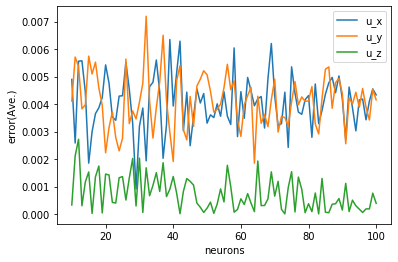

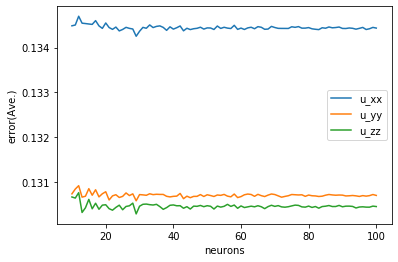

In [12]:
# plot the figure 
plt.plot(sizes, list(map(abs, dx)), label='u_x')
plt.plot(sizes, list(map(abs, dy)), label='u_y')
plt.plot(sizes, list(map(abs, dz)), label='u_z')
# plt.plot(layers, list(map(abs, dt)), label='u_t')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('error(Ave.)')
plt.show()
plt.plot(sizes, dxx, label='u_xx')
plt.plot(sizes, dyy, label='u_yy')
plt.plot(sizes, dzz, label='u_zz')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('error(Ave.)')
plt.show()

In [ ]:
def length_ratio(x, y, z, u0):
    du0 = np.array([3, 4, 5])
    ratio = ((x ** 2 + y ** 2 + z ** 2) ** 0.5 / 
             (du0[0] ** 2 + du0[1] ** 2 + du0[2] ** 2) ** 0.5)
    return ratio

print('Length ratio : {}'.format(length_ratio(ds_x, ds_y, ds_z, input_array)))

In [ ]:
import math
def theta(x, y, z, u0):
    du0 = np.array([3, 4, 5])
    mol_du0 = (du0[0] ** 2 + du0[1] ** 2 + du0[2] ** 2) ** 0.5
    mol_xyz = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    acos = math.acos(
        np.dot(du0, u0[0]) / (mol_du0 * mol_xyz))
    return acos

print('Theta : {} rad'.format(theta(ds_x, ds_y, ds_z, input_array)))